# Shapley value computation

We consider a monte carlo (or quasi-monte carlo) estimation technique before jumping to the discrete uniforme shapley value as proposed by the article.

We imagine a scenario where k players each have some data and need to pool it to collaborate on tasks :

1 - MNIST digit classification with a twist : some of the data is noisy and not all players have thus the same quality or quantity of data.

2 - An XGBoost regressor : the data is squeaky clean and well adjusted for each. The goal is to compare the featue importances with those already implemented in XGB


In [7]:
import shap
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier

# Generate synthetic data
np.random.seed(42)
data = {
    'Feature1': np.random.normal(loc=0, scale=1, size=100),
    'Feature2': np.random.normal(loc=2, scale=1.5, size=100),
    'Feature3': np.random.uniform(low=-1, high=1, size=100)
}

# Create a DataFrame
df = pd.DataFrame(data)

# Generate a target variable with some dependency
df['Target'] = df['Feature1'] * 0.5 + df['Feature2'] * 1.5 + np.random.normal(loc=0, scale=1, size=100)

X = df.drop('Target', axis=1)
y = df['Target']

# transform the target to category by binning
y = pd.qcut(y, q=2, labels=False)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = XGBClassifier().fit(X_train, y_train)

# Create the explainer and SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# Calculate mean absolute SHAP values for each feature
shap_sum = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['feature', 'shap_importance']

# Sort features by importance
importance_df = importance_df.sort_values('shap_importance', ascending=False)

# Select top features (here there are only 3)
selected_features = importance_df.head(10)['feature'].tolist()

# show the results
print(importance_df)
print(selected_features)

    feature shap_importance
1  Feature2        2.975537
0  Feature1        0.516939
2  Feature3        0.379312
['Feature2', 'Feature1', 'Feature3']


# Dataset degradation

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from utils import DU_mnist_ShapleyCalculator, run_experiment, add_noise, apply_blur, occlude_data, downsample_data, mislabel_data

# --- Configuration des scénarios et exécution des expériences ---

scenarios = {
    "noise": [0.1, 0.2, 0.3],
    "blur": [3, 5, 7],
    "occlusion": [0.1, 0.2, 0.3],
    "downsampling": [2, 3, 4],
    "mislabeling": [0.1, 0.2, 0.3]
}

num_players = [5, 10]  # Nombre de joueurs à tester
players_to_degrade = [1, 3] # En indice

results_file = "shapley_results.csv"  # Nom du fichier pour enregistrer les résultats

# --- Charger les résultats existants ---

if os.path.exists(results_file):
    resume = True
    df = pd.read_csv(results_file)
    print(f"Reprise du calcul à partir du fichier {results_file}")
else:
    df = pd.DataFrame()
    resume = False

# --- Exécution des expériences ---

all_results = []

for I in num_players:
    for degradation_type, levels in scenarios.items():
        for level in levels:
            if resume :
                # Vérifier si le scénario a déjà été traité
                if ((df['degradation_type'] == degradation_type) & 
                    (df['degradation_level'] == level) & 
                    (df['I'] == I)).any():
                    print(f"Scénario déjà traité: degradation_type={degradation_type}, degradation_level={level}, I={I}, passage au suivant.")
                    continue

            print(f"Exécution du scénario: degradation_type={degradation_type}, degradation_level={level}, I={I}")
            results = run_experiment(I, degradation_type, level, players_to_degrade)
            all_results.append(results)

            # --- Enregistrer les résultats intermédiaires ---
            for i in range(I):
                for rep in range(len(results['DU-Shapley'])):
                    new_row = pd.DataFrame({'DU-Shapley': [results['DU-Shapley'][rep][i]],
                                             'True Shapley': [results['True Shapley'][rep][i]],
                                             'degradation_type': [results['degradation_type'] if i in results['players_to_degrade'] else None], # Condition pour le type de dégradation
                                             'degradation_level': [results['degradation_level'] if i in results['players_to_degrade'] else None], # Condition pour le niveau de dégradation
                                             'I': [I],
                                             'Player': [i + 1],
                                             'Repetition': [rep + 1],
                                             'Degraded': [i in results['players_to_degrade']]})
                    df = pd.concat([df, new_row], ignore_index=True)
            df.to_csv(results_file, index=False)

Exécution du scénario: degradation_type=noise, degradation_level=0.1, I=5


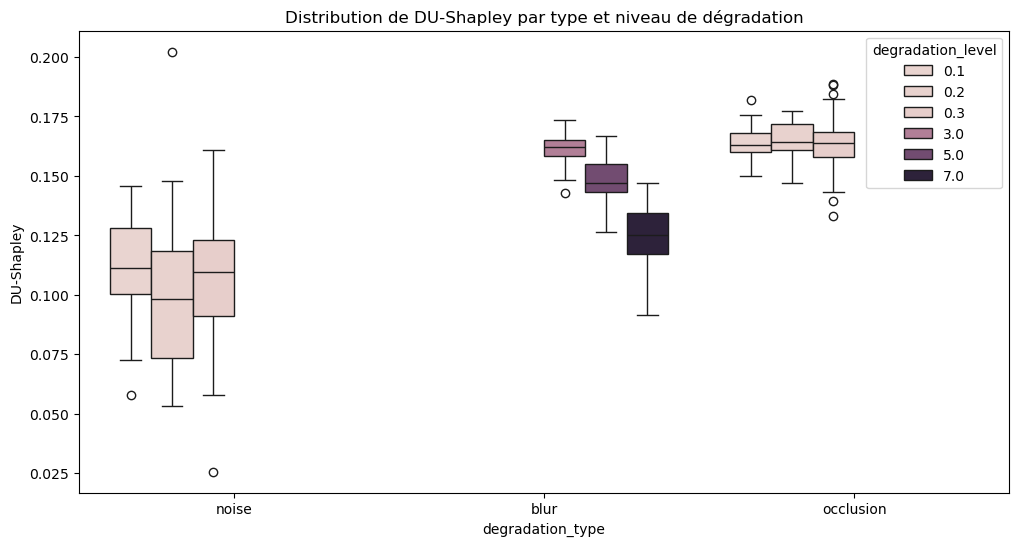

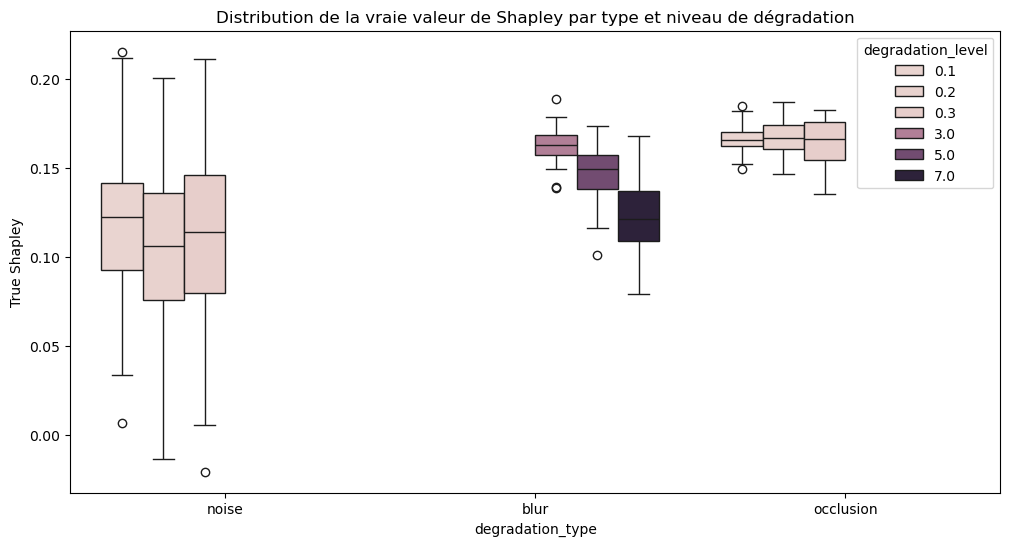

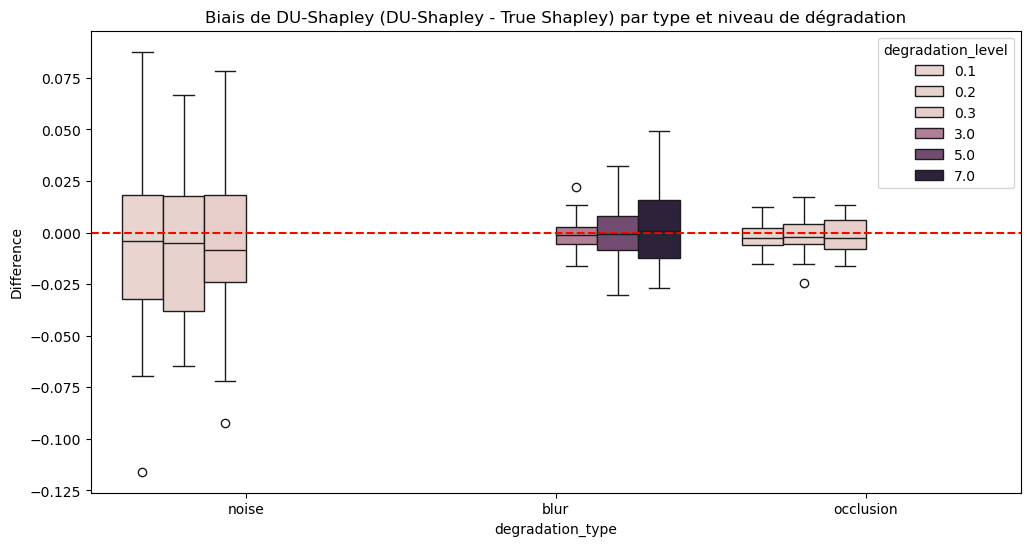

Corrélation entre DU-Shapley et True Shapley (noise, niveau 0.1, I=5): 0.433
Corrélation entre DU-Shapley et True Shapley (noise, niveau 0.1, I=10): nan
Corrélation entre DU-Shapley et True Shapley (noise, niveau 0.2, I=5): 0.610
Corrélation entre DU-Shapley et True Shapley (noise, niveau 0.2, I=10): nan
Corrélation entre DU-Shapley et True Shapley (noise, niveau 0.3, I=5): 0.638
Corrélation entre DU-Shapley et True Shapley (noise, niveau 0.3, I=10): nan
Corrélation entre DU-Shapley et True Shapley (blur, niveau 3, I=5): 0.648
Corrélation entre DU-Shapley et True Shapley (blur, niveau 3, I=10): nan
Corrélation entre DU-Shapley et True Shapley (blur, niveau 5, I=5): 0.567
Corrélation entre DU-Shapley et True Shapley (blur, niveau 5, I=10): nan
Corrélation entre DU-Shapley et True Shapley (blur, niveau 7, I=5): 0.455
Corrélation entre DU-Shapley et True Shapley (blur, niveau 7, I=10): nan
Corrélation entre DU-Shapley et True Shapley (occlusion, niveau 0.1, I=5): 0.589
Corrélation entre D

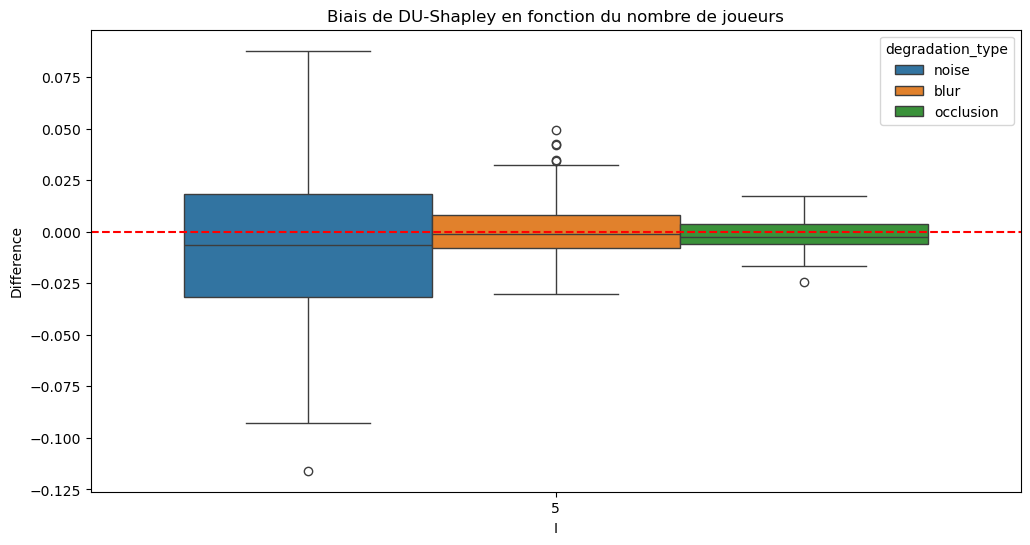

Test t pour noise, niveau 0.1, I=5:
  Statistique t: -1.156
  Valeur p: 0.253
Test t pour noise, niveau 0.1, I=10:
  Statistique t: nan
  Valeur p: nan
Test t pour noise, niveau 0.2, I=5:
  Statistique t: -0.997
  Valeur p: 0.324
Test t pour noise, niveau 0.2, I=10:
  Statistique t: nan
  Valeur p: nan
Test t pour noise, niveau 0.3, I=5:
  Statistique t: -0.350
  Valeur p: 0.728
Test t pour noise, niveau 0.3, I=10:
  Statistique t: nan
  Valeur p: nan
Test t pour blur, niveau 3, I=5:
  Statistique t: -1.071
  Valeur p: 0.290
Test t pour blur, niveau 3, I=10:
  Statistique t: nan
  Valeur p: nan
Test t pour blur, niveau 5, I=5:
  Statistique t: 0.210
  Valeur p: 0.834
Test t pour blur, niveau 5, I=10:
  Statistique t: nan
  Valeur p: nan
Test t pour blur, niveau 7, I=5:
  Statistique t: 1.217
  Valeur p: 0.230
Test t pour blur, niveau 7, I=10:
  Statistique t: nan
  Valeur p: nan
Test t pour occlusion, niveau 0.1, I=5:
  Statistique t: -2.234
  Valeur p: 0.030
Test t pour occlusion, niv

In [5]:
# --- Analyse et visualisation des résultats ---

results_file = "shapley_results.csv"
df = pd.read_csv(results_file)

# 1. Biais absolu et relatif de DU-Shapley
df['Absolute Bias'] = df['DU-Shapley'] - df['True Shapley']
df['Relative Bias'] = (df['DU-Shapley'] - df['True Shapley']) / df['True Shapley']

# 2. Visualisation du biais en fonction du type et du niveau de dégradation
plt.figure(figsize=(12, 6))
sns.boxplot(x='degradation_type', y='Absolute Bias', hue='degradation_level', data=df)
plt.title("Biais absolu de DU-Shapley par type et niveau de dégradation")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='degradation_type', y='Relative Bias', hue='degradation_level', data=df)
plt.title("Biais relatif de DU-Shapley par type et niveau de dégradation")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 3. Visualisation du biais pour les joueurs dégradés vs. non dégradés
plt.figure(figsize=(10, 6))
sns.boxplot(x='Degraded', y='Absolute Bias', hue='degradation_type', data=df)
plt.title("Biais absolu de DU-Shapley pour les joueurs dégradés vs non dégradés")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 4. Corrélation entre DU-Shapley et True Shapley
for degradation_type in scenarios.keys():
    for level in scenarios[degradation_type]:
        for I in num_players:
            subset = df[(df['degradation_type'] == degradation_type) & (df['degradation_level'] == level) & (df['I'] == I)]
            correlation = subset['DU-Shapley'].corr(subset['True Shapley'])
            print(f"Corrélation entre DU-Shapley et True Shapley ({degradation_type}, niveau {level}, I={I}): {correlation:.3f}")

# 5. Scatter plots de DU-Shapley vs True Shapley, colorés par état de dégradation
plt.figure(figsize=(8, 6))
sns.scatterplot(x='True Shapley', y='DU-Shapley', hue='Degraded', data=df)
plt.title("DU-Shapley vs True Shapley")
plt.xlabel("Vraie valeur de Shapley")
plt.ylabel("Valeur DU-Shapley")
plt.show()

# 6. Tests statistiques : comparaison des biais pour joueurs dégradés vs non dégradés
for degradation_type in scenarios.keys():
    for level in scenarios[degradation_type]:
        for I in num_players:
            subset = df[(df['degradation_type'] == degradation_type) &
                       (df['degradation_level'] == level) &
                       (df['I'] == I)]
            # Test t pour comparer le biais absolu
            t_statistic_abs, p_value_abs = stats.ttest_ind(subset['Absolute Bias'][subset['Degraded'] == True],
                                                         subset['Absolute Bias'][subset['Degraded'] == False])
            # Test t pour comparer le biais relatif
            t_statistic_rel, p_value_rel = stats.ttest_ind(subset['Relative Bias'][subset['Degraded'] == True],
                                                         subset['Relative Bias'][subset['Degraded'] == False])
            print(f"Comparaison des biais pour {degradation_type}, niveau {level}, I={I}:")
            print(f"  Test t (biais absolu): Statistique t={t_statistic_abs:.3f}, Valeur p={p_value_abs:.3f}")
            print(f"  Test t (biais relatif): Statistique t={t_statistic_rel:.3f}, Valeur p={p_value_rel:.3f}")